在第六章和第七章中，我们研究了计算机视觉中常用的各种卷积神经网络，并将它们应用到简单的图像分类任务中。 本章开头，我们将介绍两种可以改进模型泛化的方法，即**图像增广**和**微调**，并将它们应用于图像分类。

由于深度神经网络可以有效地表示多个层次的图像，因此这种分层表示已成功用于各种计算机视觉任务，例如目标检测（object detection）、语义分割（semantic segmentation）和样式迁移（style transfer）。 秉承计算机视觉中利用**分层表示**的关键思想，我们将从物体检测的主要组件和技术开始，继而展示如何使用完全卷积网络对图像进行语义分割，然后我们将解释如何使用样式迁移技术来生成像本书封面一样的图像。 最后在结束本章时，我们将本章和前几章的知识应用于两个流行的计算机视觉基准数据集。

# 13.1.图像增广(image augmentation)
图像增广在对训练图像进行一系列的随机变化之后，生成**相似但不同**的训练样本，从而扩大了训练集的规模。

此外，应用图像增广的原因是，随机改变训练样本可以**减少模型对某些属性的依赖**，从而提高模型的泛化能力。

![](../img/13_17.png)


## 13.1.1. 常用的图像增广方法

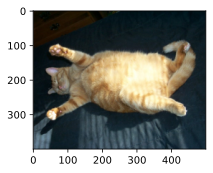

In [1]:
"""
使用下面这个尺寸为400x500的图像作为示例。
"""
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
img=d2l.Image.open('../img/cat1.jpg')
d2l.plt.imshow(img)

In [2]:
"""
大多数图像增广方法都具有一定的随机性。为了便于观察图像增广的效果，我们下面定义辅助函数apply。

此函数在输入图像img上多次运行图像增广方法aug并显示所有结果。
"""
def apply(img,aug,num_rows=2,num_clos=4,scale=1.5):
    Y=[aug(img) for _ in range(num_rows * num_clos)]
    d2l.show_images(Y,num_rows,num_clos,scale=scale)

### 翻转和裁剪
左右翻转图像通常不会改变对象的类别。这是最早且最广泛使用的图像增广方法之一。

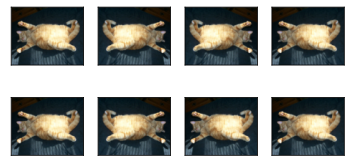

In [3]:
"""
使用transforms模块来创建RandomFlipLeftRight实例，这样就各有50%的几率使图像向左或向右翻转。
"""
apply(img,torchvision.transforms.RandomHorizontalFlip())


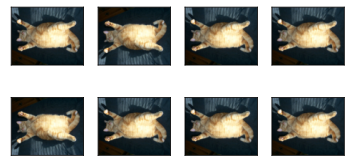

In [4]:
"""
上下翻转图像不如左右图像翻转那样常用。但是，至少对于这个示例图像，上下翻转不会妨碍识别。接下来，我们创建一个RandomFlipTopBottom实例，使图像各有50%的几率向上或向下翻转。
"""
apply(img,torchvision.transforms.RandomVerticalFlip())

在我们使用的示例图像中，猫位于图像的中间，但并非所有图像都是这样。 在 6.5节中，我们解释了**汇聚层可以降低卷积层对目标位置的敏感性**。
另外，我们可以通过对图像进行随机裁剪，**使物体以不同的比例出现在图像的不同位置**。 这也可以降低模型对目标位置的敏感性。

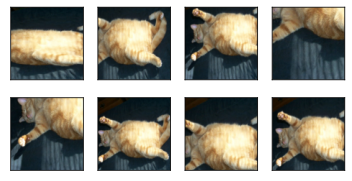

In [9]:
shape_aug=torchvision.transforms.RandomResizedCrop((200,200),
                                                   scale=(0.1,1),
                                                   ratio=(0.5,2))
apply(img,shape_aug)

### 改变颜色
另一种增广方法是改变颜色。 我们可以改变图像颜色的四个方面：亮度、对比度、饱和度和色调。

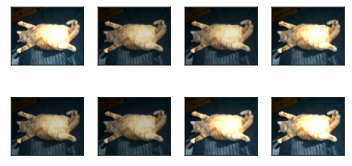

In [8]:
"""
在下面的示例中，我们随机更改图像的亮度，随机值为原始图像的50%（1-0.5）到150%（1+0.5）之间。
"""
apply(img,torchvision.transforms.ColorJitter(brightness=0.5,
                                             contrast=0,
                                             saturation=0,
                                             hue=0))

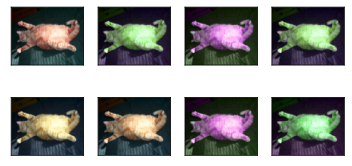

In [7]:
"""
随机更改图像的色调。
"""
apply(img,torchvision.transforms.ColorJitter(brightness=0,
                                             contrast=0,
                                             saturation=0,
                                             hue=0.5))

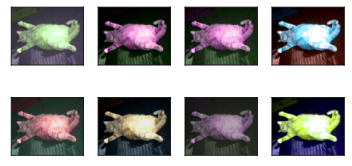

In [10]:
"""
创建一个RandomColorJitter实例，并设置如何同时随机更改图像的亮度（brightness）、对比度（contrast）、饱和度（saturation）和色调（hue）。
"""
color_aug=torchvision.transforms.ColorJitter(brightness=0.5,
                                             contrast=0.5,
                                             saturation=0.5,
                                             hue=0.5)
apply(img,color_aug)

### 结合多种图像增广方法
在实践中，我们将结合多种图像增广方法。

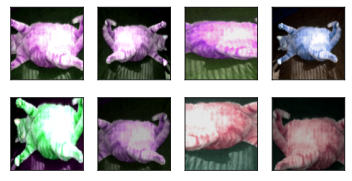

In [11]:
"""
使用一个Compose实例来综合上面定义的不同的图像增广方法，并将它们应用到每个图像。
"""
augs = torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(),
                                       color_aug,
                                       shape_aug])
apply(img,augs)

## 13.1.2. 使用图像增广进行训练
让我们使用图像增广来训练模型。 这里，我们使用CIFAR-10数据集，而不是我们之前使用的Fashion-MNIST数据集。 这是因为Fashion-MNIST数据集中对象的位置和大小已被规范化，而CIFAR-10数据集中对象的颜色和大小差异更明显。 CIFAR-10数据集中的前32个训练图像如下所示。

Files already downloaded and verified


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

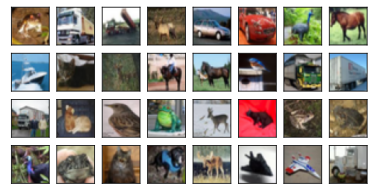

In [12]:
all_images=torchvision.datasets.CIFAR10(train=True,
                                    root="/media/zhang/Disk0/dataset/d2l/data",
                                    download=True)
d2l.show_images([all_images[i][0] for i in range(32)],4,8,scale=0.8)

为了在预测过程中得到确切的结果，我们通常**对训练样本只进行图像增广，且在预测过程中不使用随机操作的图像增广**。 在这里，我们只使用最简单的随机左右翻转。 此外，我们使用ToTensor实例将一批图像转换为深度学习框架所要求的格式，即形状为（批量大小，通道数，高度，宽度）的32位浮点数，取值范围为0到1。

In [13]:
train_augs=torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()])

test_augs=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

"""
接下来，我们定义一个辅助函数，以便于读取图像和应用图像增广。
PyTorch数据集提供的transform参数应用图像增广来转化图像。有关DataLoader的详细介绍，请参阅 3.5节。
"""
def load_cifar10(is_train,augs,batch_size):
    dataset = torchvision.datasets.CIFAR10(root='/media/zhang/Disk0/dataset/d2l/data',train=is_train,transform=augs,download=True)
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,shuffle=is_train,
                                             num_workers=d2l.get_dataloader_workers())
    return dataloader

### 多GPU训练
我们在CIFAR-10数据集上训练7.6节中的ResNet-18模型。 回想一下12.6节中对多GPU训练的介绍。

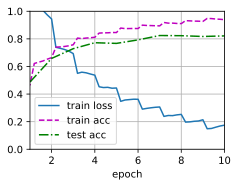

loss 0.174, test acc0.821, 1679.8 examples/sec on [device(type='cuda', index=0)]


In [14]:
#@save
def train_batch_ch13(net,X,y,loss,trainer,devices):
    """用多GPU进行小批量训练"""
    if isinstance(X,list):
        # 微调BERT中所需（稍后讨论）
        X=[x.to(devices[0]) for x in X]
    else:
        X=X.to(devices[0])
    y=y.to(devices[0])

    net.train()
    trainer.zero_grad()
    pred=net(X)

    l=loss(pred,y)
    l.sum().backward()
    trainer.step()
    train_loss_sum=l.sum()
    train_acc_sum=d2l.accuracy(pred,y)
    return train_loss_sum,train_acc_sum

#@save
def train_13(net,train_iter,test_iter,loss,trainer,num_epochs,devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer,num_batches=d2l.Timer(),len(train_iter)
    animator=d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0,1],legend=['train loss','train acc','test acc'])
    net=nn.DataParallel(net,device_ids=devices).to(devices[0])

    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric=d2l.Accumulator(4)
        for i,(features,labels) in enumerate(train_iter):

            timer.start()

            l,acc=train_batch_ch13(net,features,labels,loss,trainer,devices)

            metric.add(l,acc,labels.shape[0],labels.numel())

            timer.stop()

            if (i+1)%(num_batches//5)==0 or i==num_batches-1:
                animator.add(epoch+(i+1)/num_batches,
                             (metric[0]/metric[2],metric[1]/metric[3],
                              None))
        test_acc=d2l.evaluate_accuracy_gpu(net,test_iter)
        animator.add(epoch+1,(None,None,test_acc))
    animator.show()
    print(f'loss {metric[0]/metric[2]:.3f}, test acc{test_acc:.3f}, {metric[2]*num_epochs/timer.sum():.1f} examples/sec on {str(devices)}')

"""
现在，我们可以定义train_with_data_aug函数，使用图像增广来训练模型。该函数获取所有的GPU，并使用Adam作为训练的优化算法，将图像增广应用于训练集，最后调用刚刚定义的用于训练和评估模型的train_ch13函数
"""
batch_size,devices,net=256,d2l.try_all_gpus(),d2l.resnet18(10,3)

def init_weights(m):
    if type(m) in [nn.Linear,nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs,test_augs,net,lr=0.001):
    train_iter=load_cifar10(True,train_augs,batch_size)
    test_iter=load_cifar10(False,test_augs,batch_size)
    loss=nn.CrossEntropyLoss(reduction='none')
    trainer=torch.optim.Adam(net.parameters(),lr=lr)
    train_13(net,train_iter,test_iter,loss,trainer,10,devices)

"""
使用基于随机左右翻转的图像增广来训练模型。
"""
train_with_data_aug(train_augs,test_augs,net)


## 13.1.3. 小结
- 图像增广基于现有的训练数据生成随机图像，来提高模型的泛化能力。
- 为了在预测过程中得到确切的结果，我们通常对训练样本只进行图像增广，而在预测过程中不使用带随机操作的图像增广。
- 深度学习框架提供了许多不同的图像增广方法，这些方法可以被同时应用。